In [153]:
import numpy as np
import scipy.integrate 
import matplotlib.pyplot as plt
import matplotlib.colors 
import tqdm
import scipy.signal
import statsmodels.tsa.stattools
import statsmodels.api as sm
import statsmodels.tsa.seasonal
import string

Questions: 
how to compute ar and var
isn't the accumulating effect and a slower time series contra each other at small lamda?


In [154]:
#define time interval, T should be integer
T = 5000

def mu(t):
    return 2/T * t - 1

def f(x,t): 
    return (x - x**3 /3.0 - mu(t))

In [155]:
def get_upper():
    n = T + 1
    ts = np.linspace(0,T,n)
    upper = np.zeros(n)

    for i in tqdm.trange(n):
        sol = scipy.integrate.solve_ivp(lambda t,x: f(x,ts[i]),(0.0,100),[2.0],method="BDF")
        upper[i] = sol.y[0,-1]

    return ts, upper

In [156]:
ts, upper = get_upper()

  1%|          | 38/5001 [00:00<00:26, 188.65it/s]c:\Users\mdichgan\AppData\Local\miniconda3\envs\bachelor_thesis\lib\site-packages\scipy\integrate\_ivp\bdf.py:416: RuntimeWarning: invalid value encountered in subtract
  D[order + 2] = d - D[order + 1]
100%|██████████| 5001/5001 [00:42<00:00, 117.38it/s]


In [165]:
#numerical simulation of SDEs:

steps_per_unit_time = 10                                           
solve_ts = np.linspace(0,T,T*steps_per_unit_time + 1)
dt = 1/steps_per_unit_time



#white noise case

xs_white = np.zeros(T*steps_per_unit_time + 1)
# xs_white[0] = 2.103803356099623
xs_white[0] = 2.07

sigma = 0.05
white_noise = np.random.normal(0,np.sqrt(dt),T*steps_per_unit_time)


for i in tqdm.trange(T*steps_per_unit_time):
    xs_white[i+1] = xs_white[i] + f(xs_white[i],solve_ts[i])*dt + sigma*white_noise[i]


# wiener = np.zeros(T*steps_per_unit_time + 1)
# wiener[0] = 2.07
# for i in tqdm.trange(T*steps_per_unit_time):
#     wiener[i+1] = wiener[i] + sigma*white_noise[i]


#red noise case

xs_red = np.zeros(T*steps_per_unit_time+1)
xs_red[0] = 2.103803356099623                                                           #upper[0]
kappa = 0.1                                                                    #shouldn't be too small 

def eta(theta):
    eta = np.zeros(T*steps_per_unit_time)
    for i in tqdm.trange(T*steps_per_unit_time - 1):
        eta[i+1] = np.exp(-theta*dt)*eta[i] + np.sqrt(1/(2*theta)*(1-np.exp(-2*theta*dt)))*np.random.normal(0,1)
    return eta

eta = eta(1)


for i in tqdm.trange(T*steps_per_unit_time):
    xs_red[i+1] = xs_red[i] + f(xs_red[i],solve_ts[i])*dt + kappa*eta[i]*dt



xs_white_filtered = xs_white[::steps_per_unit_time]
xs_red_filtered = xs_red[::steps_per_unit_time]


100%|██████████| 50000/50000 [00:00<00:00, 467426.71it/s]


In [197]:
start_t = 2000
stop_t = 2050

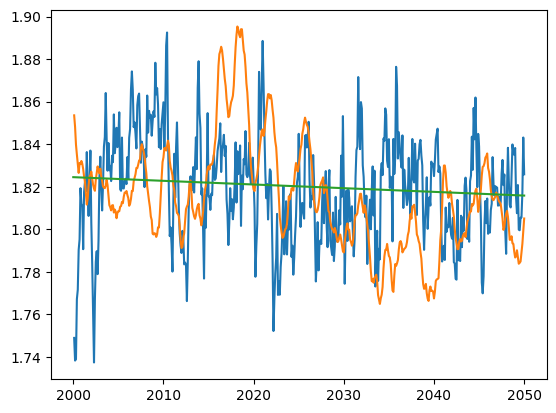

In [198]:
#all steps from unit time i to unit time j

n_steps = (stop_t - start_t)*steps_per_unit_time

plt.plot(np.linspace(start_t + dt,stop_t,n_steps),xs_white[start_t*steps_per_unit_time + 1:stop_t*steps_per_unit_time + 1])

plt.plot(np.linspace(start_t + dt,stop_t,n_steps),xs_red[start_t*steps_per_unit_time + 1:stop_t*steps_per_unit_time + 1])

plt.plot(ts[start_t:stop_t + 1],upper[start_t:stop_t + 1])


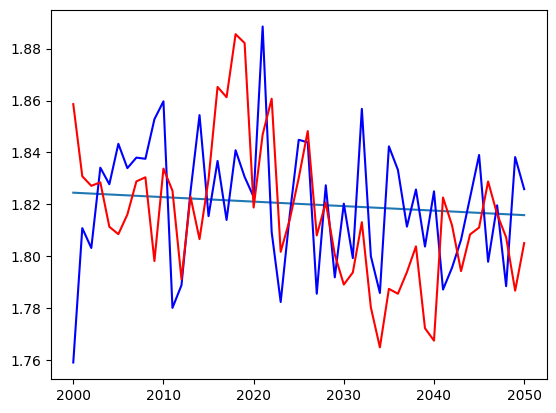

In [199]:
#filtered time series

plt.plot(np.arange(start_t,stop_t + 1),upper[start_t:stop_t + 1])
plt.plot(np.arange(start_t,stop_t + 1),xs_white_filtered[start_t:stop_t + 1],color = "blue")
plt.plot(np.arange(start_t,stop_t + 1),xs_red_filtered[start_t:stop_t + 1], color = "red")

In [88]:
#version with var and ar over several time units

window_length = 50 

def get_var(x):
    #get var of T-windows with length window length. Gives n_windows values
    n_windows = int(T/window_length) 
    var = np.full(n_windows,np.nan)
    for i in tqdm.trange(n_windows):
        var[i] = statsmodels.tsa.tsatools.detrend(x[i*window_length:(i+1)*window_length],order=2).var()
    return var
        
        
    
def get_ar(x):
    #get ar of T-windows with length window length. Gives n_windows values
    n_windows = int(T/window_length) 
    ar = np.full(n_windows,np.nan)
    for i in tqdm.tgrange(n_windows):
        ar[i] = statsmodels.tsa.stattools.acf(statsmodels.tsa.tsatools.detrend(x[i*steps_per_unit_time:(i+1)*steps_per_unit_time],order=2))[1]
    return ar

In [ ]:
#version with var and ar over several time units

variance_series_white = get_var(xs_white_filtered)
variance_series_red = get_var(xs_red_filtered)
ac_series_white = get_ar(xs_white_filtered)
ac_series_red = get_ar(xs_red_filtered)

In [177]:
#version with var and ar for each time unit

def get_var_per_time_unit(x):
    #computes var of detrended time series for the T frames [0,1),...,[T-1,T)
    #x should have size T*steps_per_unit_time + 1   
    var = np.full(T+1,np.nan)
    for i in tqdm.trange(T):
        var[i+1] = statsmodels.tsa.tsatools.detrend(x[i*steps_per_unit_time:(i+1)*steps_per_unit_time],order=2).var()
    return var
        
        
    
def get_ar_per_time_unit(x):
    #x should have size T*steps_per_unit_time + 1
    ar = np.full(T+1,np.nan)
    for i in tqdm.tgrange(T):
        ar[i+1] = statsmodels.tsa.stattools.acf(statsmodels.tsa.tsatools.detrend(x[i*steps_per_unit_time:(i+1)*steps_per_unit_time],order=2))[1]
    return ar

100%|██████████| 5000/5000 [00:00<00:00, 10188.34it/s]
c:\Users\mdichgan\AppData\Local\miniconda3\envs\bachelor_thesis\lib\site-packages\tqdm\gui.py:181: TqdmExperimentalWarning: GUI is experimental/alpha
  return tqdm_gui(range(*args), **kwargs)


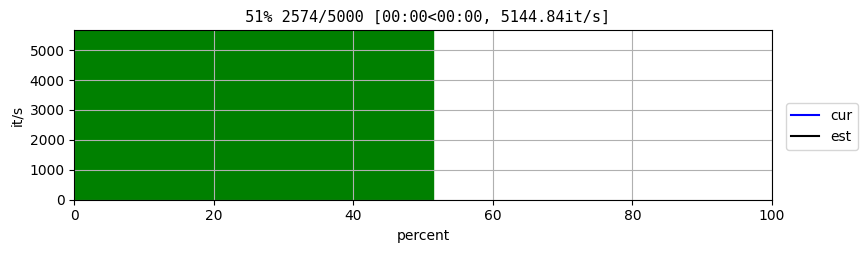

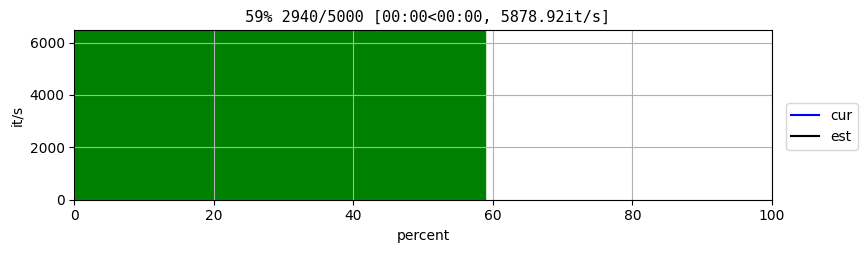

In [179]:
#version with var and ar for each time unit

variance_series_white_ptu = get_var_per_time_unit(xs_white)
variance_series_red_ptu = get_var_per_time_unit(xs_red)
ac_series_white_ptu = get_ar_per_time_unit(xs_white)
ac_series_red_ptu = get_ar_per_time_unit(xs_red)

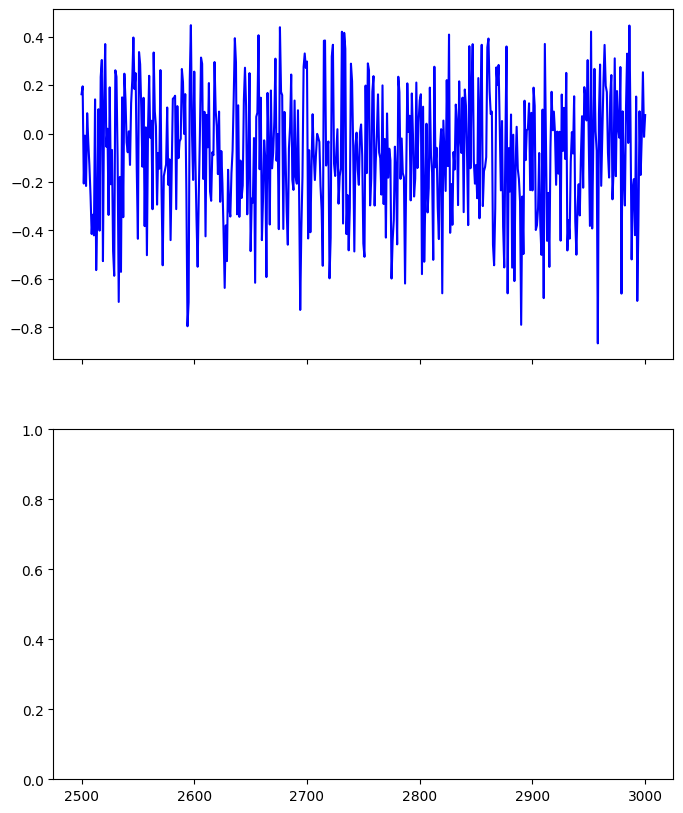

In [190]:
fig,axs = plt.subplots(nrows=2,ncols=1,sharex=True,figsize=(8,10)) 

axs[0].plot(np.arange(start_t,stop_t + 1), ac_series_white_ptu[start_t:stop_t + 1],color = "blue")
# ax0_var = axs[0].twinx()
# ax0_var.plot(np.arange(start_t,stop_t + 1), variance_series_white_ptu[start_t:stop_t + 1], color = "blue", linestyle = "--")


# axs[1].plot(np.arange(start_t,stop_t + 1), ac_series_red_ptu[start_t:stop_t + 1],color = "red")
# ax0_var = axs[1].twinx()
# ax0_var.plot(np.arange(start_t,stop_t + 1), variance_series_red_ptu[start_t:stop_t + 1], color = "red", linestyle = "--")


In [ ]:
fig,axs = plt.subplots(nrows=2,ncols=1,sharex=True,figsize=(8,10)) 

axs[0].plot(np.arange(start_t, stop_t +1)[window_length::window_length],log_ac_white[:n_windows],color="blue")                               
ax0_var = axs[0].twinx()
ax0_var.plot(np.arange(up_to_time + 1)[window_length::window_length],variance_series_white[:n_windows],color="blue",linestyle="--")


axs[1].plot(np.arange(up_to_time + 1)[window_length::window_length],log_ac_red[:n_windows],color="red")
ax1_var = axs[1].twinx()
ax1_var.plot(np.arange(up_to_time + 1)[window_length::window_length],variance_series_red[:n_windows],color="red",linestyle="--")

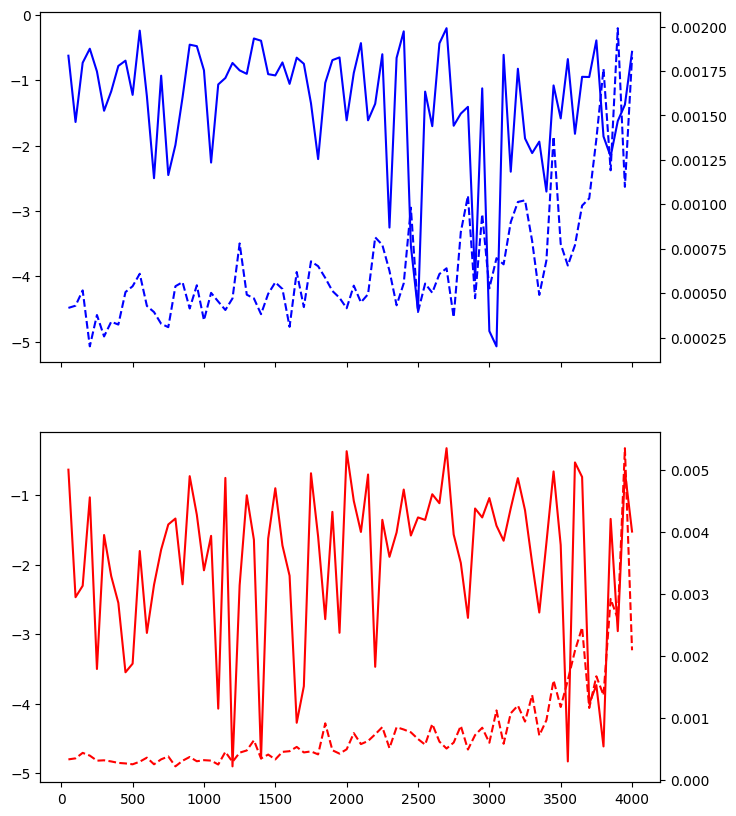

In [121]:


n_windows = int(up_to_time / window_length)

fig,axs = plt.subplots(nrows=2,ncols=1,sharex=True,figsize=(8,10)) 

axs[0].plot(np.arange(up_to_time + 1)[window_length::window_length],log_ac_white[:n_windows],color="blue")                               
ax0_var = axs[0].twinx()
ax0_var.plot(np.arange(up_to_time + 1)[window_length::window_length],variance_series_white[:n_windows],color="blue",linestyle="--")


axs[1].plot(np.arange(up_to_time + 1)[window_length::window_length],log_ac_red[:n_windows],color="red")
ax1_var = axs[1].twinx()
ax1_var.plot(np.arange(up_to_time + 1)[window_length::window_length],variance_series_red[:n_windows],color="red",linestyle="--")